In [ ]:
# 목표 : 타이타닉에 탑승한 사람들의 신상정보를 활용하여, 승선한 사람들의 생존여부를 예측하는 모델을 생성하자!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) # matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일히 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<ipython-input-2-0b535a025190>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


1. Dataset 확인

In [7]:
df_train = pd.read_csv('./titanic/train.csv')
df_test = pd.read_csv('./titanic/test.csv')

In [8]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


1.1 Null data check

In [12]:
for col in df_train.columns:
  msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
  print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [13]:
for col in df_test.columns:
  msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
  print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


- Train, Test set 에서 Age(둘다 약 20%), Cabin(둘다 약 80%), Embarked(Train만 0.22%) null data 존재하는 것을 확인.
- MANO 라는 라이브러리를 사용하면  null data 의 존재를 더 쉽게 확인 가능.

<Axes: >

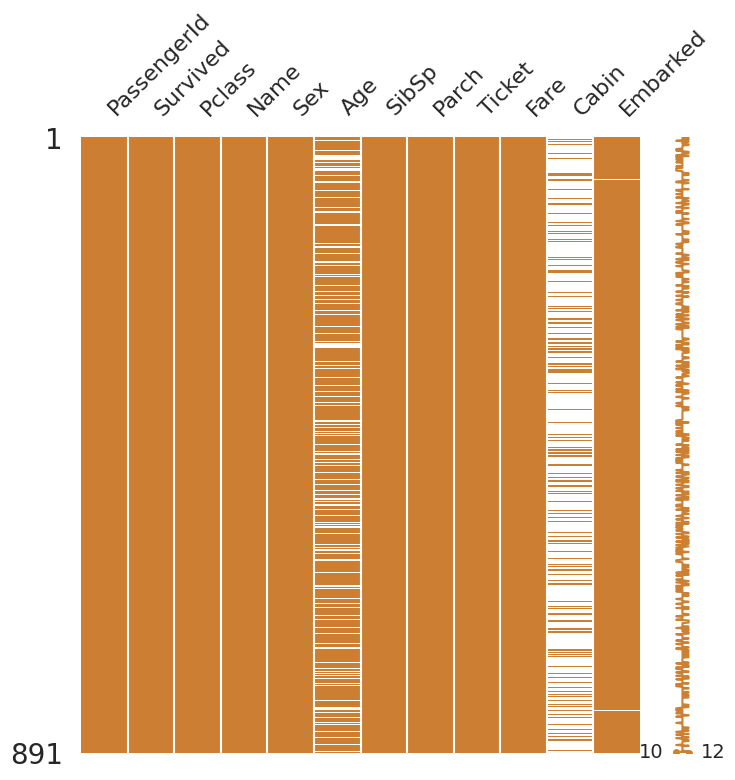

In [14]:
msno.matrix(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<Axes: >

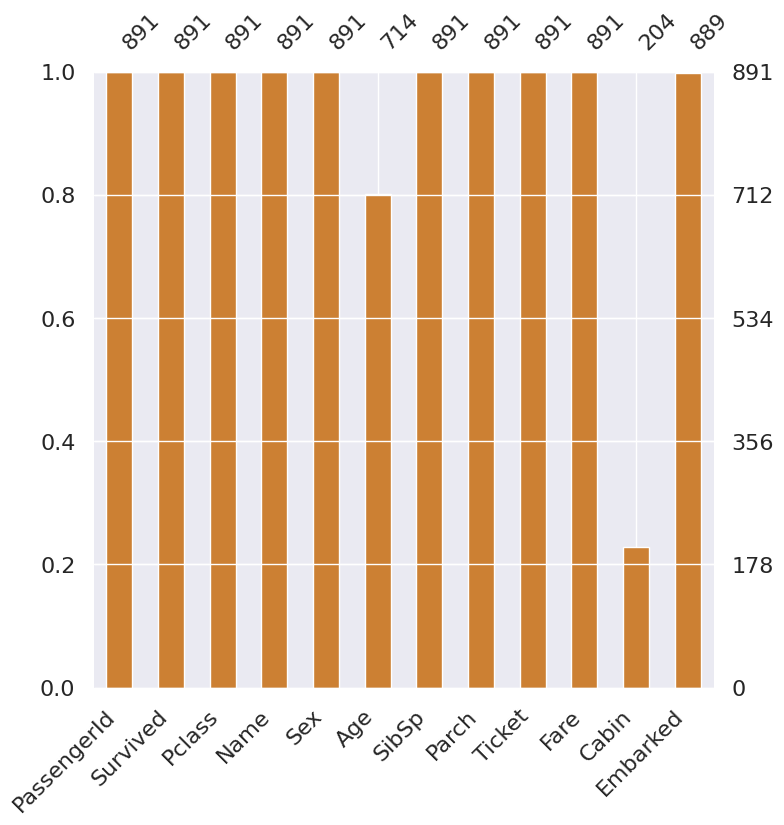

In [15]:
msno.bar(df=df_train.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

<Axes: >

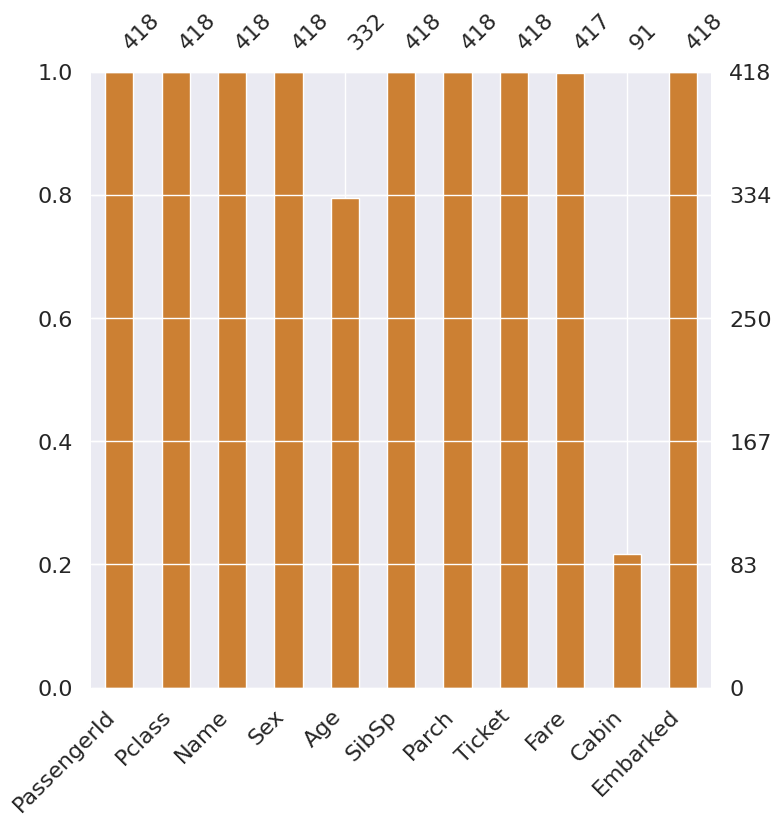

In [16]:
msno.bar(df=df_test.iloc[:,:], figsize=(8, 8), color=(0.8, 0.5, 0.2))

1.2 Target label 확인
- target label 이 어떤 distribution 을 가지고 있는 지 확인해봐야 함.
- 지금 같은 binary classification 문제의 경우에서, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있음.

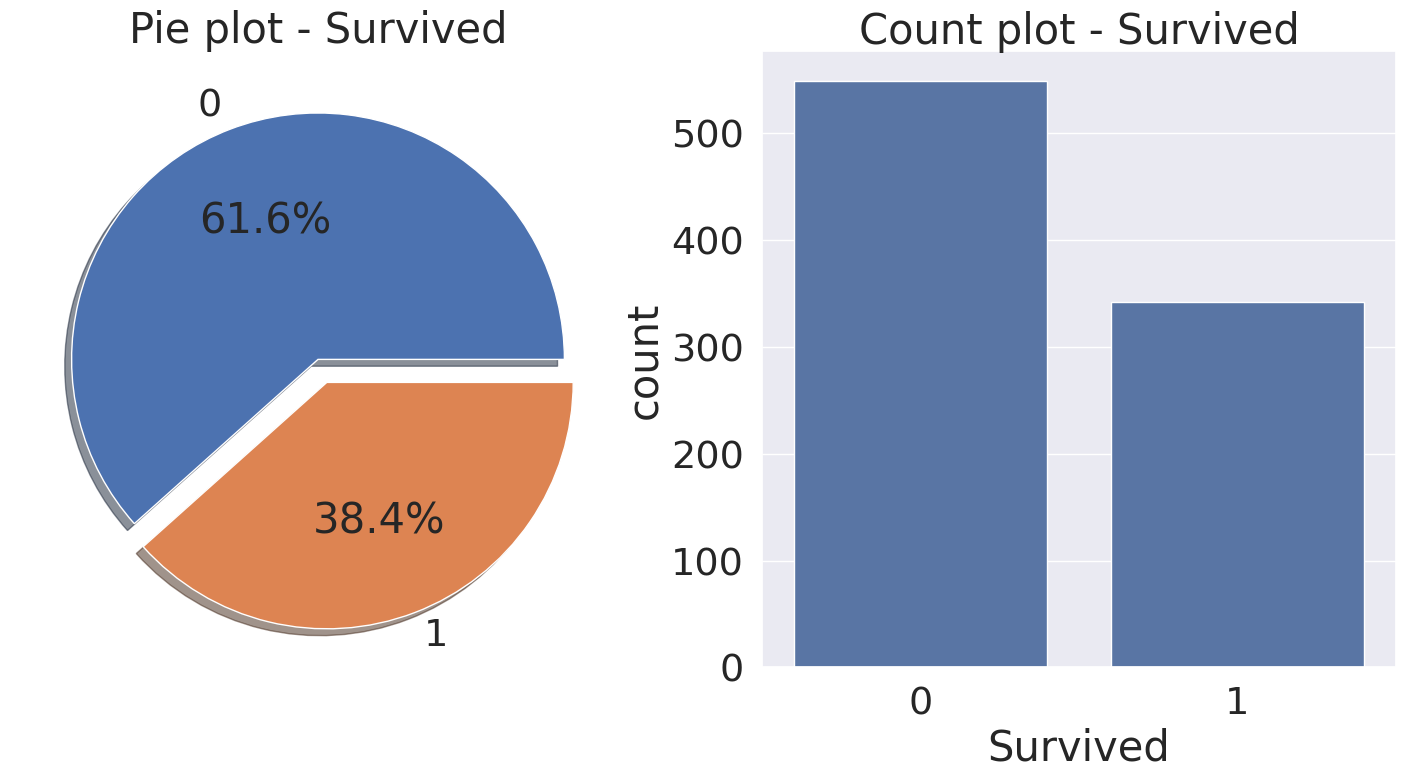

In [22]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=df_train, ax=ax[1]) # countplot() got multiple values for argument 'data' : x를 명시해주니 에러 해결
ax[1].set_title('Count plot - Survived')

plt.show()

- 61.1% 사망, 38.4% 생존
- target label 의 분포가 제법 균일(balanced)
- 만일 불균일했다면 문제 발생

2. Exploratory data analysis

2.1 Pclass
- Pclass는 ordinal, 서수형 데이터
- 카테고리이면서, 순서가 있는 데이터타입
- Pclass에 따른 생존률의 차이를 살펴보자

In [23]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count() # 각 클래스 인원

,Survived
Pclass,
1,216
2,184
3,491


In [24]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum() # 각 클래스 생존 인원

,Survived
Pclass,
1,136
2,87
3,119


In [26]:
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


<Axes: xlabel='Pclass'>

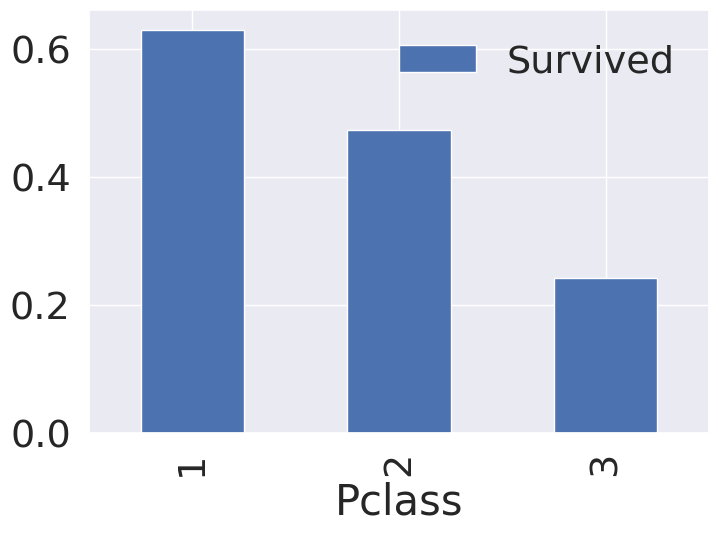

In [27]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

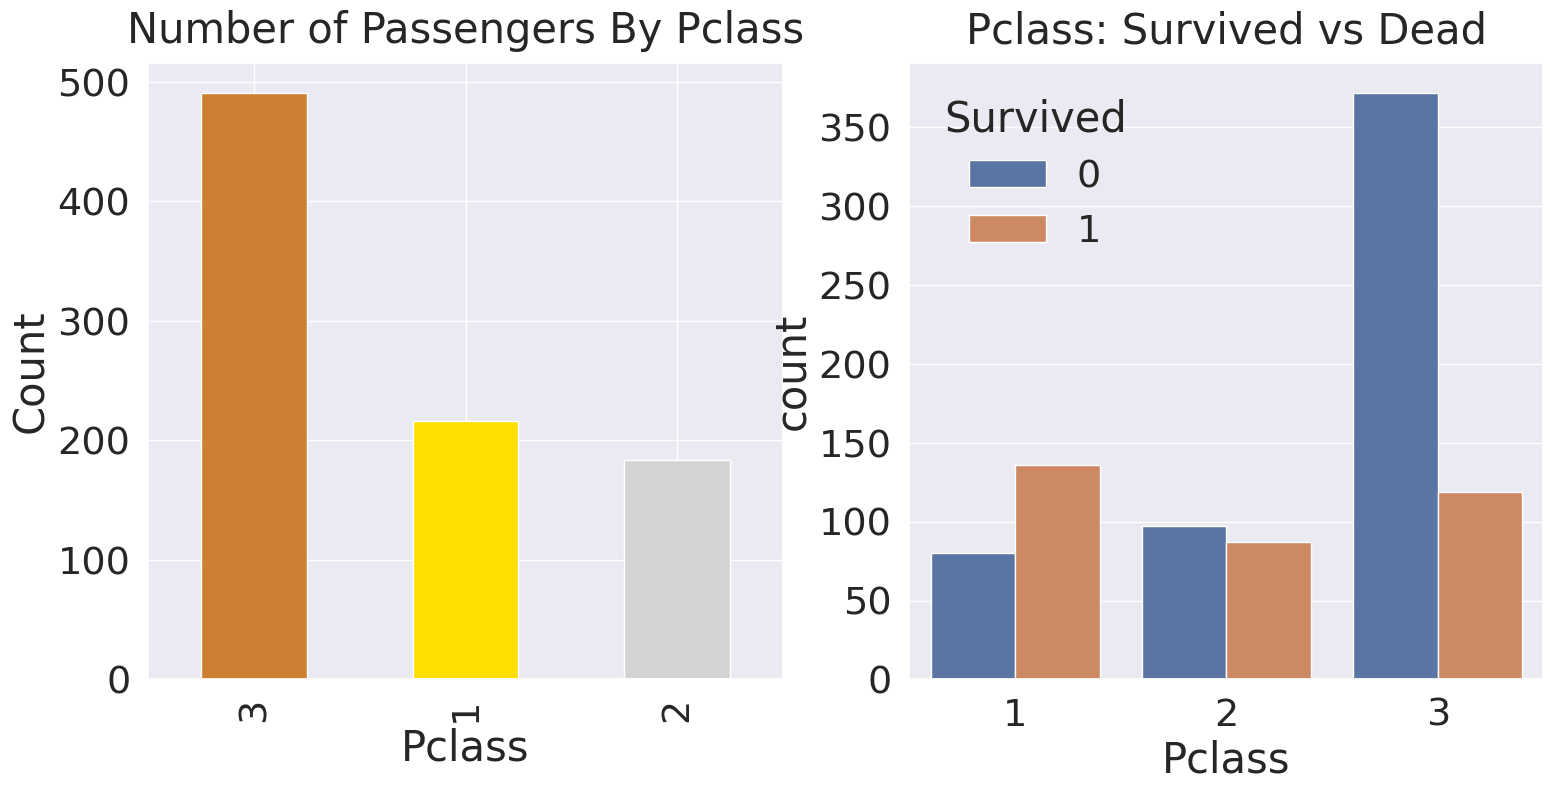

In [29]:
y_position = 1.02
f, ax = plt.subplots(1, 2, figsize=(18, 8))
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass', y=y_position)
ax[0].set_ylabel('Count')
sns.countplot(x='Pclass', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
plt.show()

- 클래스가 높을 수록, 생존 확률이 높은 걸 확인 가능.
- Pclass 1, 2, 3 순서대로 63%, 48%, 25%

2.2 Sex
- 성별에 따른 생존률의 차이를 알아보자

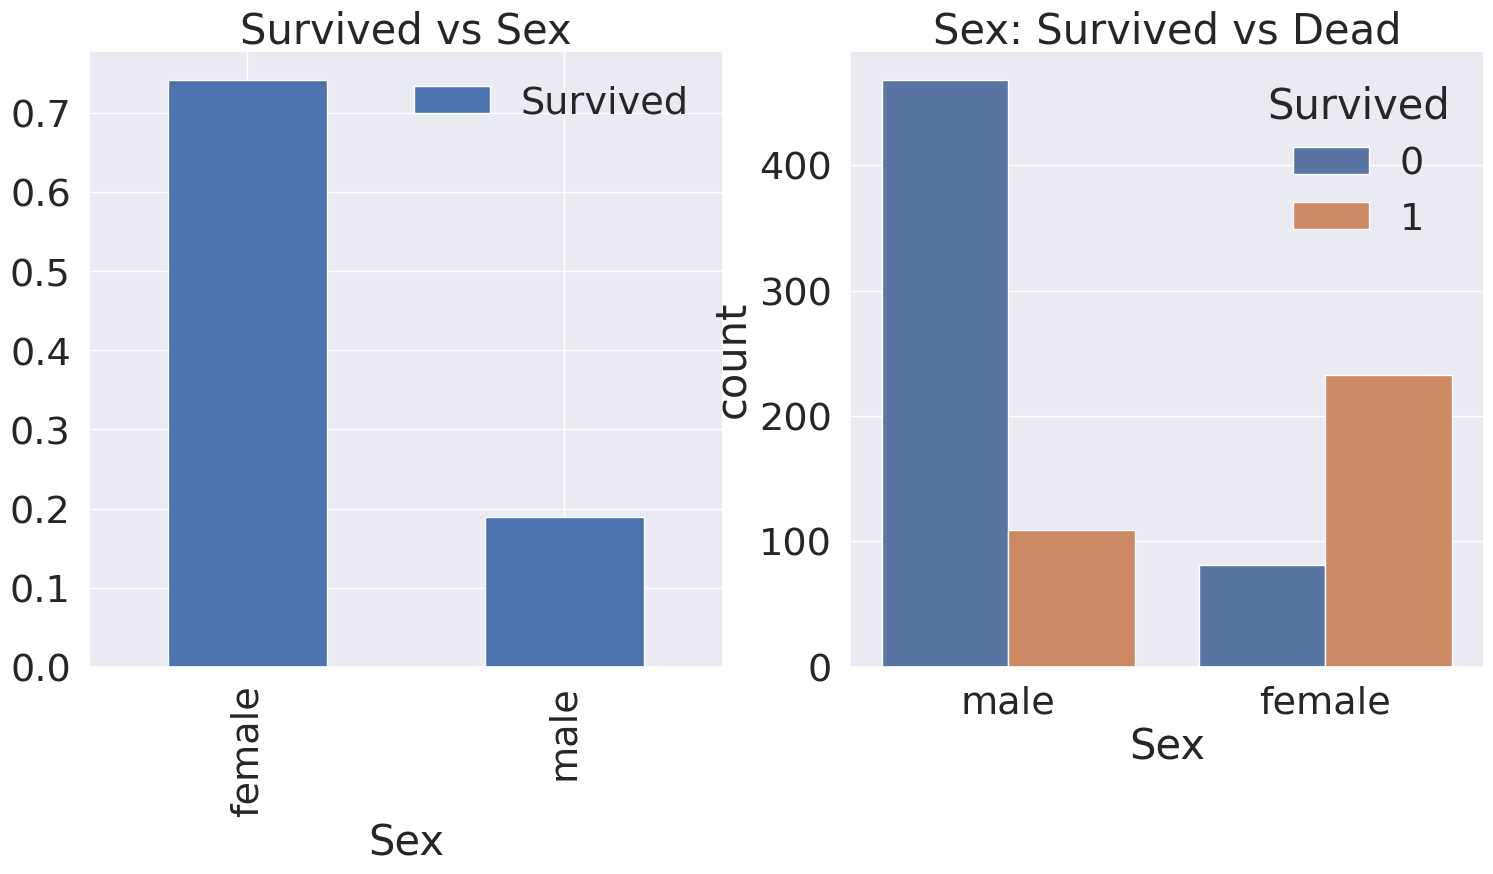

In [31]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
plt.show()

In [32]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [33]:
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


- 여자가 생존할 확률이 높음을 할 수 있음.

2.3 Both Sex and Pclass
- Sex, Pclass 두가지에 관하여 생존이 어떻게 달라지는 지 확인해보자

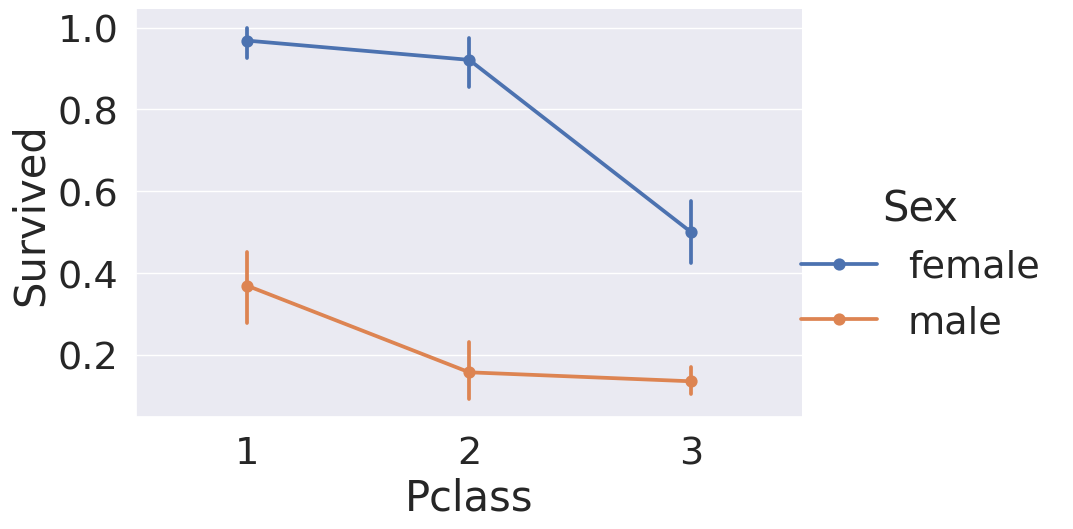

In [36]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=df_train,
               kind='point', height=6, aspect=1.5)

- 모든 클래스에서 여자가 더 살 확률이 높음
- 여자 남자 상관없이 클래스가 높으면 더 살 확률이 높음

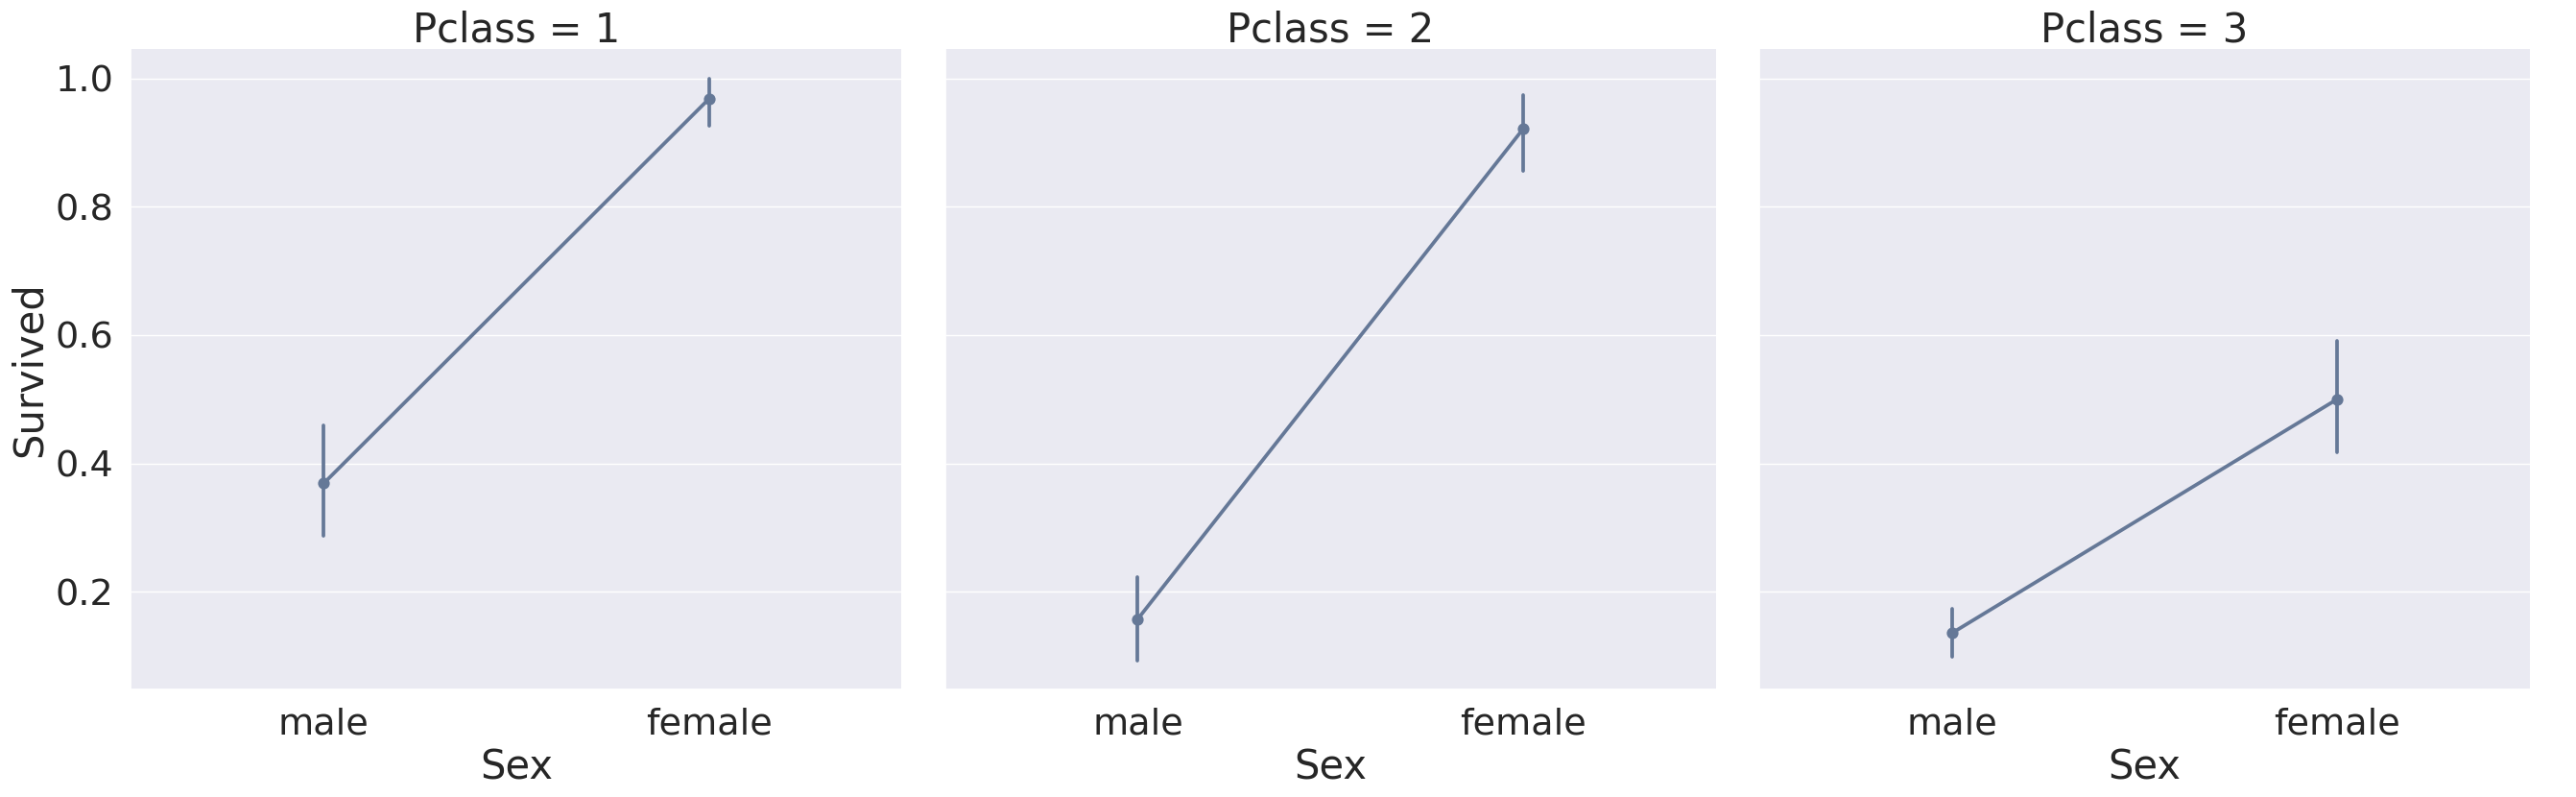

In [37]:
sns.catplot(x='Sex', y='Survived', col='Pclass', data=df_train,
            saturation=.5, height=9, aspect=1, kind='point')


2.4 Age
- Age 에 따라 생존 확률을 살펴보자

In [38]:
print('제일 나이 많은 탑승객 : {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객 : {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이 : {:.1f} Years'.format(df_train['Age'].mean()))


제일 나이 많은 탑승객 : 80.0 Years
제일 어린 탑승객 : 0.4 Years
탑승객 평균 나이 : 29.7 Years


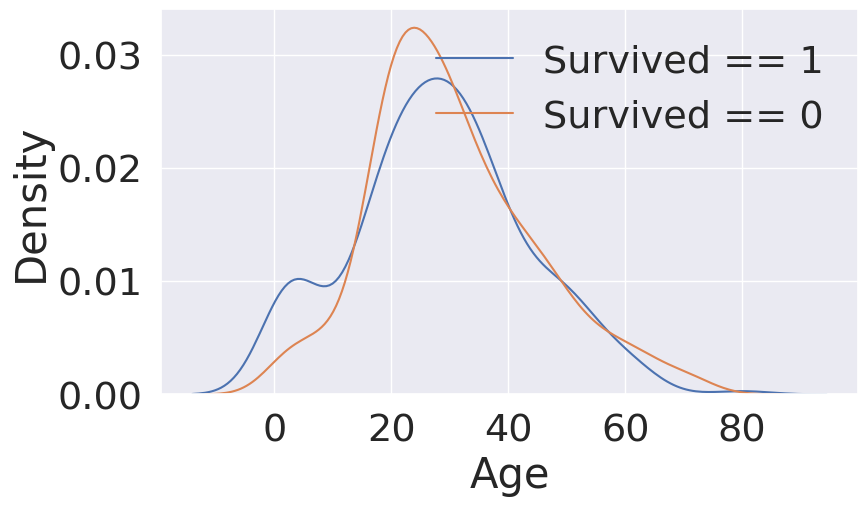

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived == 1', 'Survived == 0'])
plt.show()

- 생존자 중 나이가 어린 경우가 많음을 볼 수 있음.

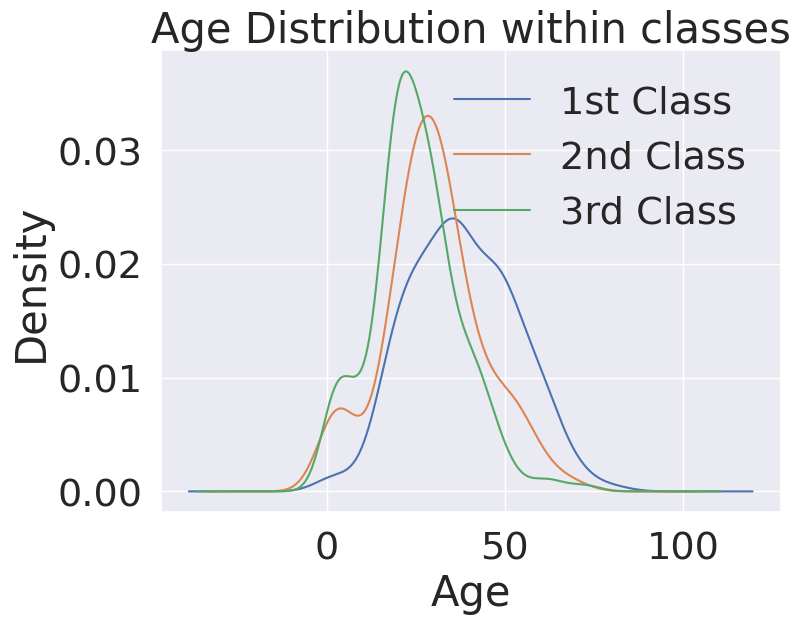

In [40]:
# Age distributio withing classes
plt.figure(figsize=(8, 6))
df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde')

plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st Class', '2nd Class', '3rd Class'])

- 클래스가 높을 수록 나이 많은 사람들의 비중이 커짐.

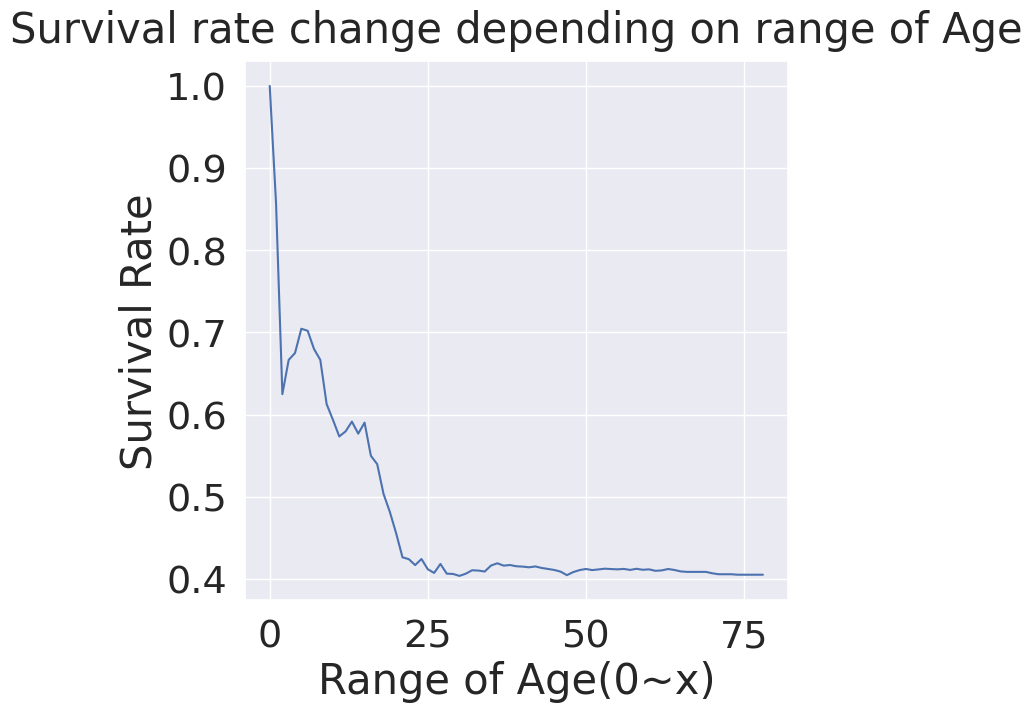

In [42]:
cummulate_survival_ratio = []
for i in range(1, 80):
  cummulate_survival_ratio.append(df_train[df_train['Age'] < i]['Survived'].sum()/
                                  len(df_train[df_train['Age'] <i]['Survived']))

plt.figure(figsize=(7, 7))
plt.plot(cummulate_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival Rate')
plt.xlabel('Range of Age(0~x)')
plt.show()

- 나이가 어릴 수록 생존률이 확실히 높음

2.5 Pclass, Sex, Age

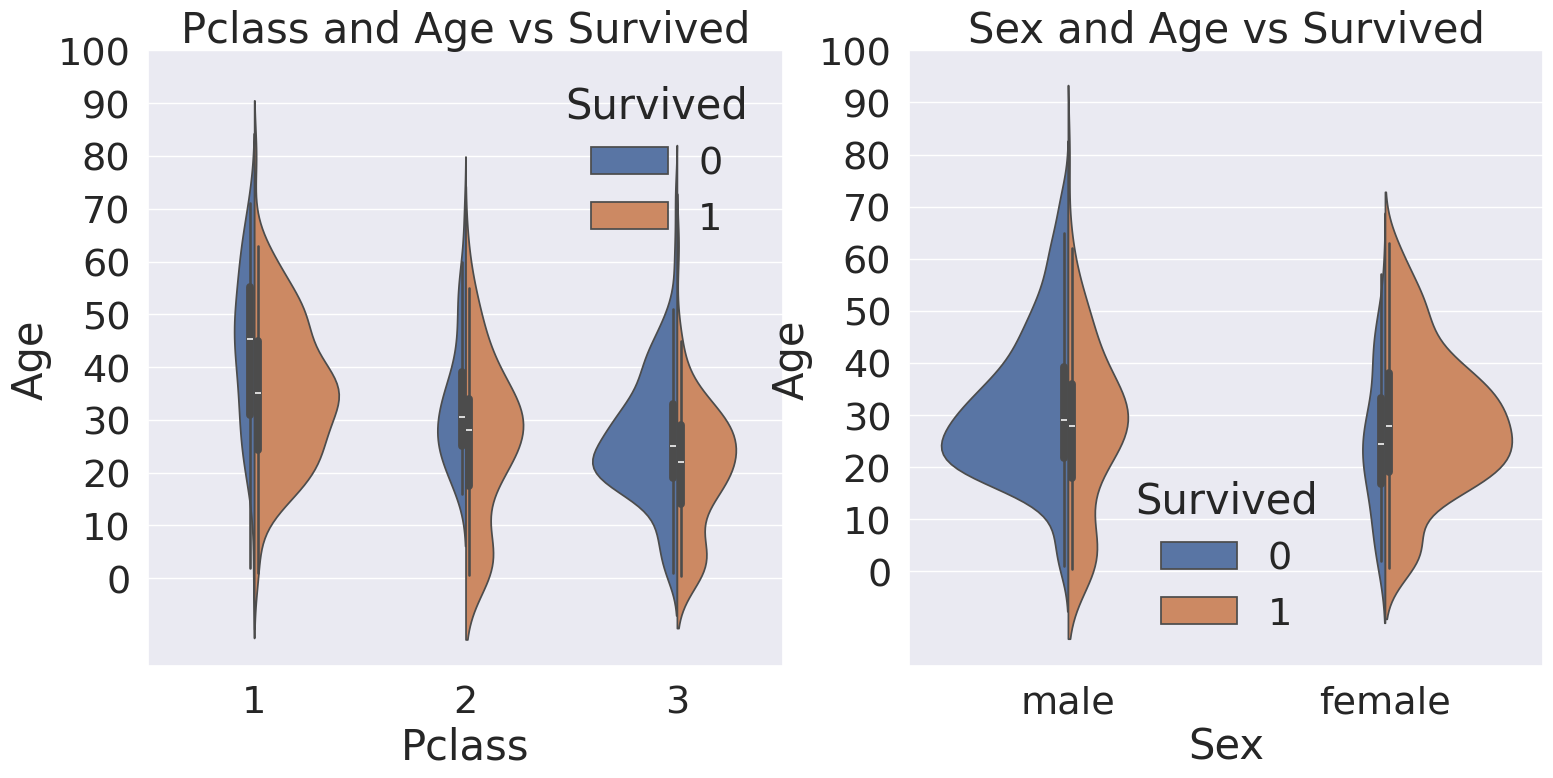

In [45]:
f, ax = plt.subplots(1, 2, figsize=(18,8))
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=df_train, scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot(x="Sex", y="Age", hue="Survived", data=df_train, scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

- 왼쪽 그림은 Pclass 별로 Age 의 distribution 이 어떻게 다른지, 거기에 생존 여부에 따라 구분한 그래프
- 오른쪽 그림도 마찬가지로 Sex 별로 Age, 생존 distribution 이 어떻게 다른지 보여주는 그래프
- 생존만 봤을 때, 모든 클래스에서 나이가 어릴 수록 생존을 많이 했음을 알 수 있음.
- 오른쪽 그림을 보면, 명확히 여자가 더 생존을 많이 했음을 알 수 잇음.
- 여성과 아이를 먼저 챙긴 것을 볼 수 있음.

2.6 Embarked
- Embarked는 탑승한 항구를 나타냄

<Axes: xlabel='Embarked'>

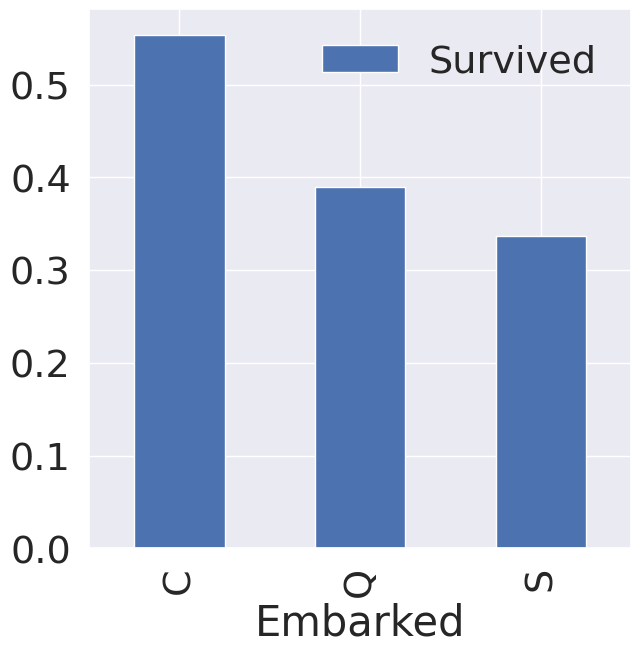

In [46]:
f, ax = plt.subplots(1, 1, figsize=(7, 7))
df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax)

- 조금의 차이는 있지만 비슷. C가 제일 생존률 높음.

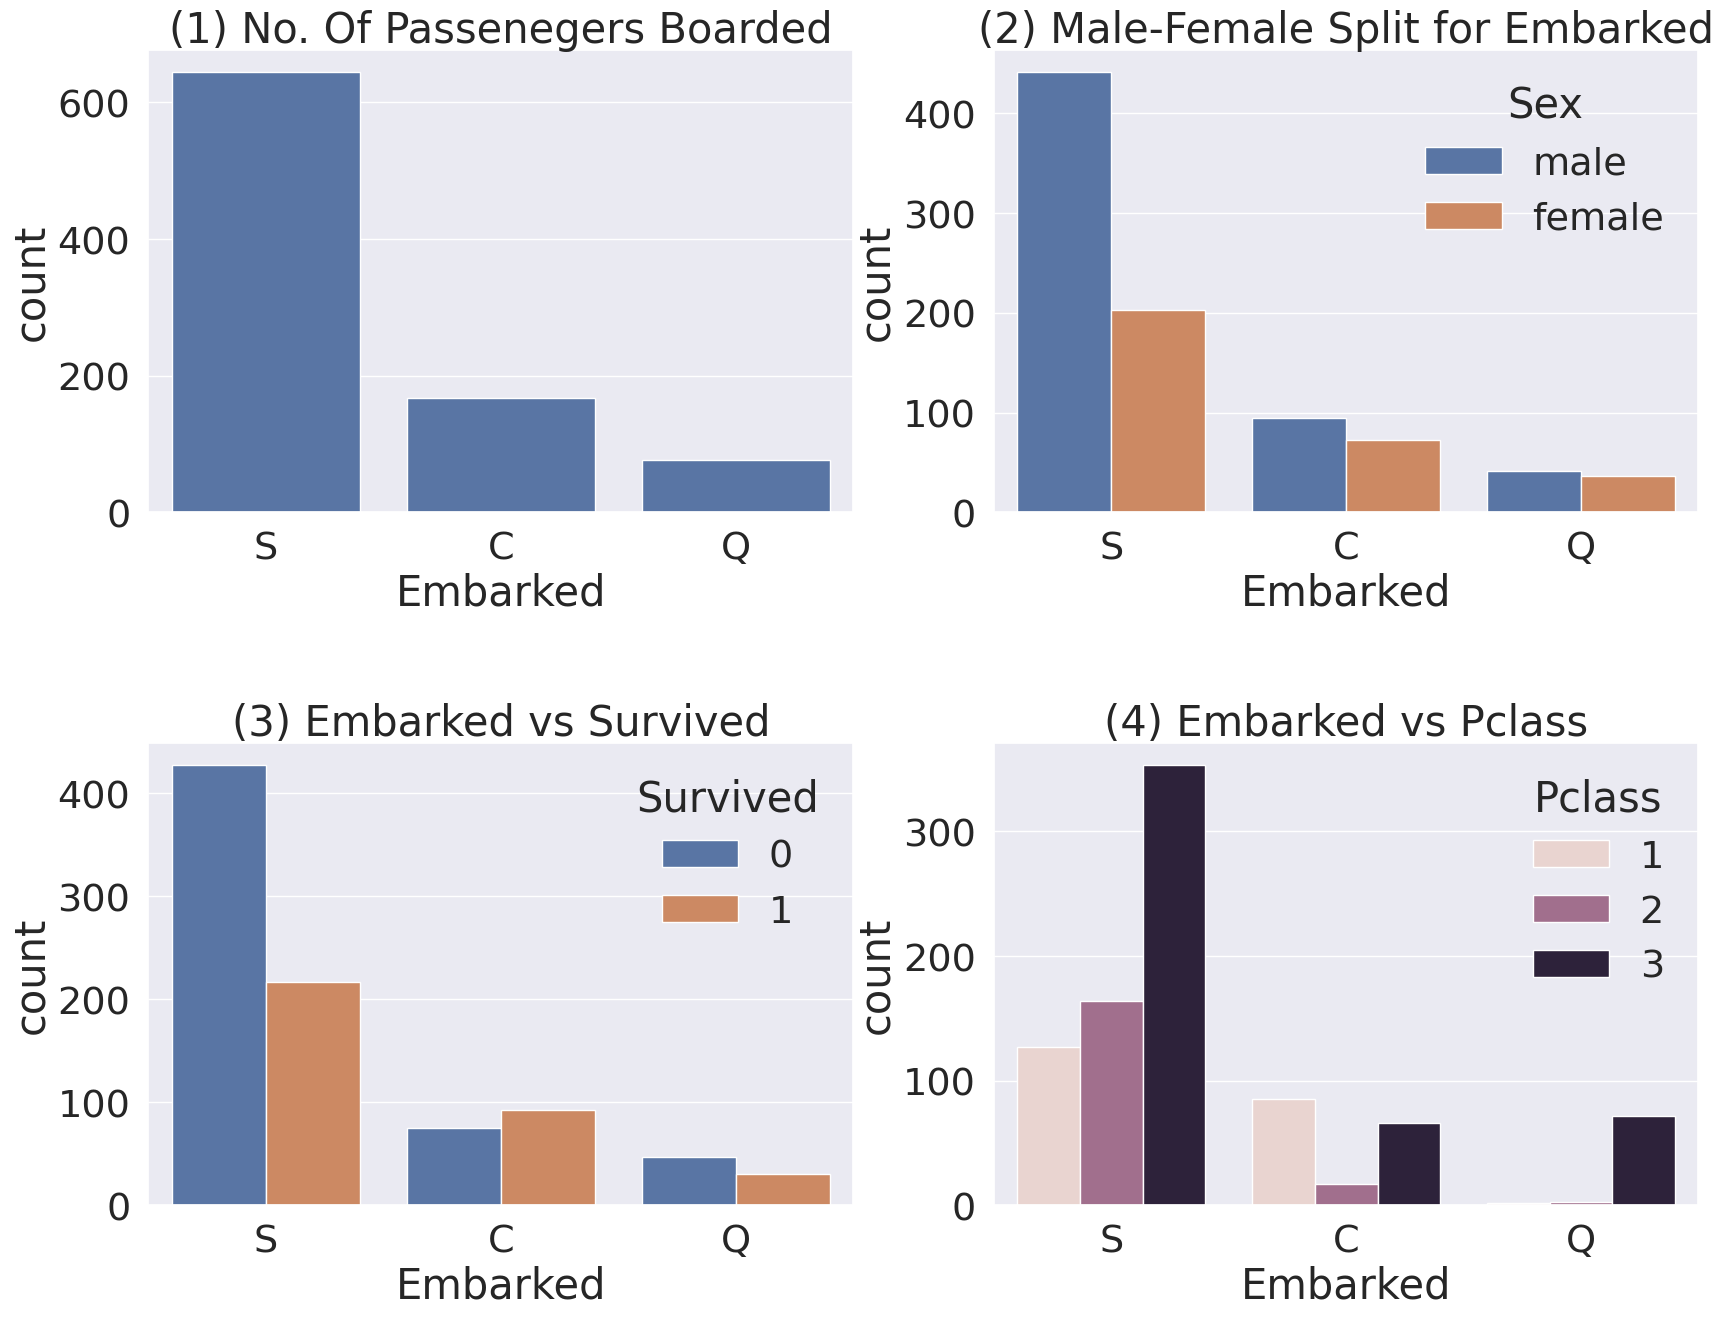

In [48]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
sns.countplot(x='Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No. Of Passenegers Boarded')
sns.countplot(x='Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot(x='Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot(x='Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) - 전체적으로 봤을 때, S 에서 가장 많은 사람이 탑승했음.
- Figure(2) - C와 Q는 남녀 비율 비슷, S는 남자가 더 많음.
- Figure(3) - 생존확률이 S의 경우 많이 낮음.
- Figure(4) - Class로 split해서 보니, C가 생존확률이 높은 것은 클래스가 높은 사람들이 많이 탔기 때문임. S는 3rd class가 많아서 생존확률이 낮게 나옴.

2.7 Family - SibSp(형제 자매) + Parch(부모, 자녀)
- SibSp 와 Parch 를 합하면 Family 가 될 것임.
- Family 로 합쳐서 분석.

In [49]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 포함해야 하니 1을 더합니다
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 # 자신을 포함해야 하니 1을 더합니다

In [50]:
print("Maximum size of Family: ", df_train['FamilySize'].max())
print("Minimum size of Family: ", df_train['FamilySize'].min())

Maximum size of Family:  11
Minimum size of Family:  1


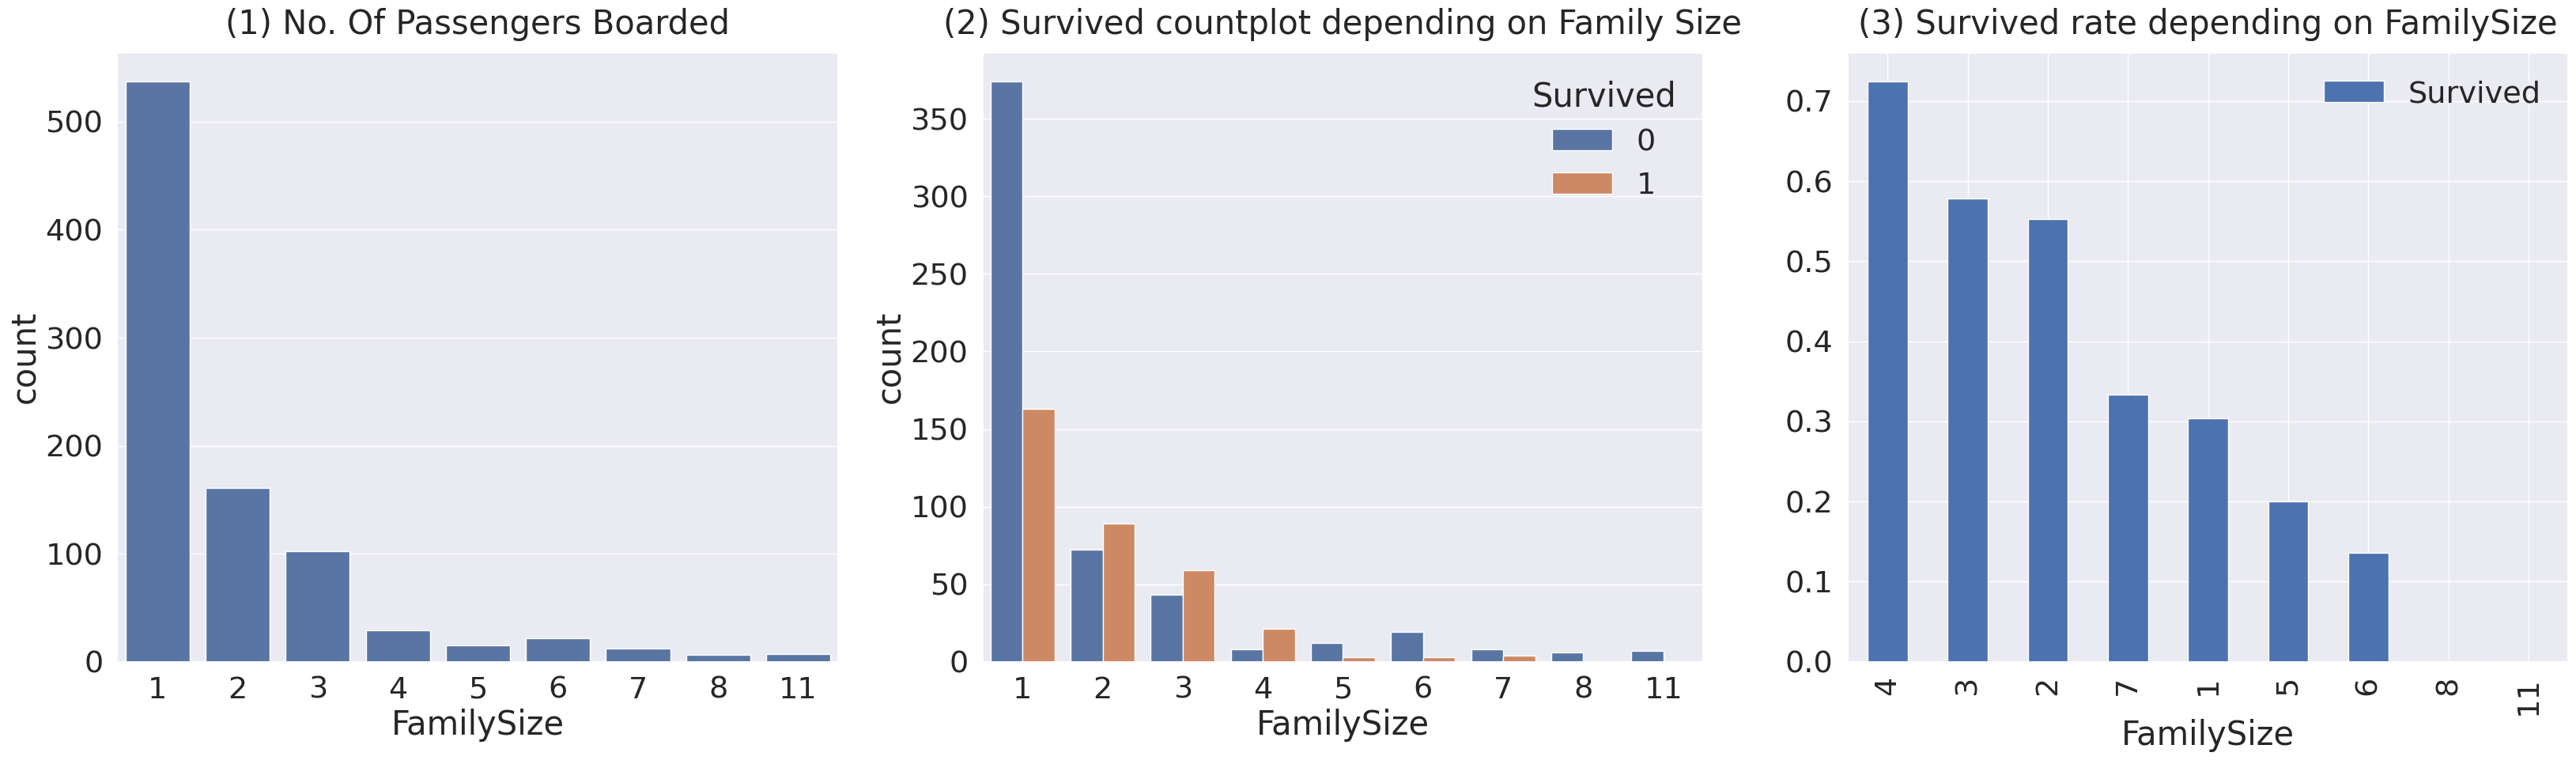

In [51]:
f, ax = plt.subplots(1, 3, figsize=(40, 10))
sns.countplot(x='FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. Of Passengers Boarded', y=1.02)

sns.countplot(x='FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on Family Size', y=1.02)

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar(ax=ax[2])
ax[2].set_title('(3) Survived rate depending on FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

- Figure(1) - 가족 크기가 1~11까지 있음. 대부분 1명, 그다음으로 2,3,4명.
- Figure(2), (3) - 가족 크기에 따른 생존비교. 가족이 4명인 경우가 가장 생존 확률이 높음.
- 가족수가 많아질수록, (5, 6, 8, 11) 생존 확률이 낮아짐. 가족 수가 너무 작아도(1), 너무 커도(5, 6, 8, 11) 생존 확률이 낮음. 3~4명 선에서 생존확률이 높음.

2.8 Fare
- Fare 는 탑승요금이며, contious feature

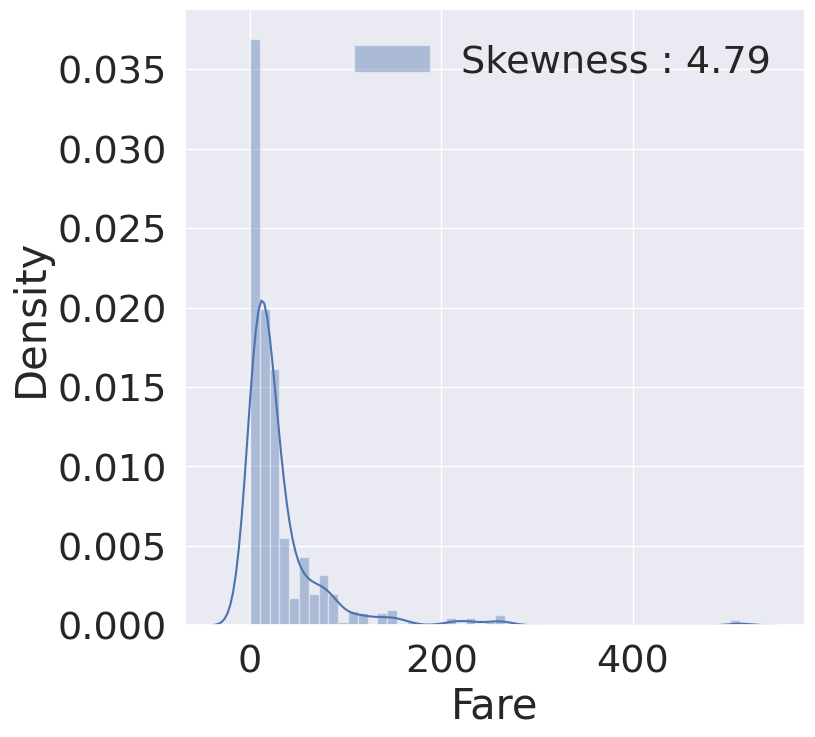

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- distribution 이 매우 비대칭. (high skewness) 만약 이대로 모델에 넣으면 자칫 모델이 잘못 학습할 수 있음. 몇개 없는 outlier 에 너무 민감하게 반응한다면 실제 예측 시에 좋지 못한 결과를 부를 수 있음.
- outlier 의 영향을 줄이기 위해 Fare 에 log 를 취하겠음.

In [54]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean() # testset 에 있는 nan value 를 평균값으로 치환

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

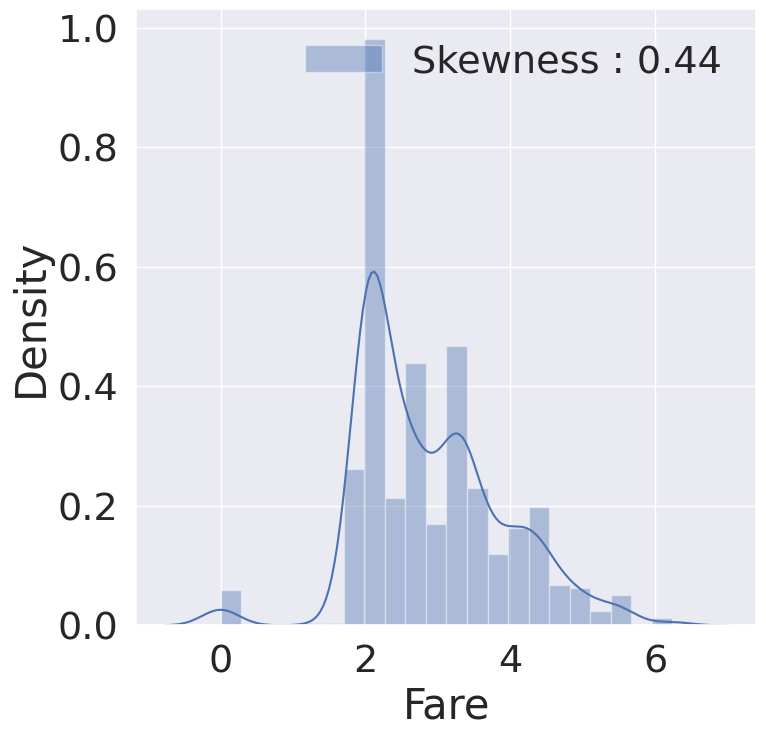

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- log 를 취하니 비대칭성이 많이 사라짐.
- 모델을 학습시키기 위해, 그리고 그 모델의 성능을 높이기 위해 feature 들에 여러 조작을 가하거나, 새로운 feature 를 추가하는 것을 feature engineering 이라고 함.

2.9 Cabin (객실 번호)
- NaN 이 대략 80% 이므로, 생존에 영향을 미칠 중요한 정보를 얻어내기 쉽지 않음.
- 모델에 포함하지 않기로 함.

In [57]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,1.981001,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,4.266662,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.972177,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.085672,NaN,S,1


2.10 Ticket
- string data 이므로 어떤 작업을 해주어야 실제 모델에 사용할 수 있는데, 이를 위해서는 아이디어가 필요함.

In [58]:
df_train['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

- ticket number 는 매우 다양함. 여기서 어떤 특징을 이끌어내서 생존과 연결시킬 수 있을까?